In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import pickle
from sklearn import svm
import parselmouth
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pathology Overview 

In [ ]:
# Define the best results
min_acc = 0.34 # 0.8577
min_sen = 0.0 # 0.8759
min_spe = 1 # 0.8394

# Below what threshold should be the rare pathology deleted?
thresh = 5

In [3]:
# Load the file_information table
table_info = pd.read_csv(Path("datasets", "file_information.csv"))
print(table_info.shape)
table_info = table_info[["sessionid", "pathologies"]]
table_info.drop(table_info[table_info.pathologies.isna()].index, inplace=True)
print(table_info.shape)

# Finding rare pathologies
pathologies = []
indices = []
for idx,value in zip(table_info.sessionid.values, table_info.pathologies.values):
    pathologies += value.replace(" ", "").split(",")
    indices += [idx] * len(value.replace(" ", "").split(","))
    
pathology_counts = pd.Series(pathologies).value_counts().reset_index()


table_info_individual_pathology = pd.DataFrame({"sessionid": indices, "pathology": pathologies})
pathology_counts.sort_values("count")




(2225, 10)
(1356, 2)


,index,count
70,Papillom,1
51,MedialeHalscyste,1
53,Mesopharynxtumor,1
54,MorbusParkinson,1
55,Hyperasthenie,1
...,...,...
4,Dysphonie,101
3,FunktionelleDysphonie,112
2,Laryngitis,140
1,Rekurrensparese,213


# Patient oveview

In [20]:
table_info = pd.read_csv(Path("datasets", "file_information.csv"))
table_info = table_info[table_info.talkerage > 16]
table_info["age_binned"] = pd.qcut(table_info.talkerage, 4)
table_info["has_pathology"] = pd.notna(table_info.pathologies)
table_info.talkersex = table_info.talkersex.replace("w", "f")
table_info.groupby(["talkersex", "age_binned", "has_pathology"])["sessionid"].count().to_excel("dataset_info_for_article.xlsx")

C:\Users\stein\AppData\Local\Temp\ipykernel_15144\3183082298.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_info.groupby(["talkersex", "age_binned", "has_pathology"])["sessionid"].count().to_excel("dataset_info_for_article.xlsx")


In [22]:
table_info.groupby(["talkersex", "age_binned"])["sessionid"].count()

C:\Users\stein\AppData\Local\Temp\ipykernel_15144\3942669353.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_info.groupby(["talkersex", "age_binned"])["sessionid"].count()


talkersex  age_binned    
f          (16.999, 24.0]    375
           (24.0, 41.0]      271
           (41.0, 58.0]      278
           (58.0, 94.0]      231
m          (16.999, 24.0]    196
           (24.0, 41.0]      289
           (41.0, 58.0]      250
           (58.0, 94.0]      303
Name: sessionid, dtype: int64

# Check results

In [ ]:
# Get all result files
results_dir = Path("results")
file_list = list(results_dir.glob("**/results.csv"))

# Prepare a table for results
table_results = pd.DataFrame(columns=["folder", "options", "acc", "sen", "spe"], data=[])

# Iterate through each result file
for file in file_list[:]:
    # UUID
    folder = str(file.parent).split('\\')[1]
    table = pd.read_csv(file)
    # Add each row to the results table
    for row_index in range(table.shape[0]):
        table_results.loc[table_results.shape[0], :] = [folder] + table.iloc[row_index, [0, 1, -2, -1]].tolist()
    
# Drop low results
for col, metric in zip(["acc", "sen", "spe"], [min_acc, min_sen, min_spe]):
    table_results.drop(table_results[table_results[col] < metric].index, inplace=True)
    
table_results

In [ ]:
# Train classifier for each good result
for idx, (name, option) in enumerate(zip(table_results.folder, table_results.options)):
    # Dataset loading
    training_data_dir = Path("training_data").joinpath(name)
    
    train_set = pickle.load(open(training_data_dir.joinpath("train_set.pk"), "rb"))
    test_set = pickle.load(open(training_data_dir.joinpath("test_set.pk"), "rb"))
    
    input_train = np.array(train_set["data"])
    input_test = np.array(test_set["data"])
    input_total = np.concatenate((input_train, input_test), axis=0)
    
    label_train = np.array(train_set["labels"])
    label_test = np.array(test_set["labels"])
    label_total = np.array(train_set["labels"] + test_set["labels"])
    
    index_train = np.array(train_set["index"])
    index_test = np.array(test_set["index"])
    index_total = np.array(train_set["index"] + test_set["index"])
    
    # Classifier options
    c, weight, kernel, gamma, degree = option[1:-1].split(", ")
    clf = svm.SVC(kernel=kernel.replace("'", ""), gamma=gamma.replace("'",""), degree=int(degree), class_weight={0: int(weight) / 10}, C=float(c))

    # Training the classifier
    clf.fit(input_train, label_train)
    
    # # Validating the classifier (just to be sure about the reproducibility
    # y_pred = clf.predict(input_test)
    # TN, FP, FN, TP = confusion_matrix(label_test, y_pred).ravel()
    # acc = accuracy_score(label_test, y_pred)
    # sen = recall_score(label_test, y_pred)
    # spe = TN / (TN + FP)
    # print((c, weight, kernel, gamma, degree), acc, sen, spe)
    
    # Predicting ALL values to see which samples are incorrectly identified
    y_pred = clf.predict(input_total)
    # Incorrect predictions
    misclassified_idx = index_total[y_pred != label_total]
    misclassified_pathologies = table_info[table_info["sessionid"].isin(misclassified_idx)]
    
    individual_pathologies = []
    for item in misclassified_pathologies["pathologies"].values:
        individual_pathologies += item.replace(" ", "").split(",")
        
    print(pd.Series(individual_pathologies).value_counts())
    
    

# Other shit

## Number of samples

In [ ]:
path = Path("datasets")

files = list(path.glob("**/*.wav"))
len(files)

## Problematic samples (under age limit or without a fundamental frequency estimation)

In [68]:
problematic = ['803-a_n', '807-a_n', '808-a_n', '1048-a_n', '1084-a_n', '1162-a_n', '1243-a_n', '1252-a_n', '1316-a_n', '1323-a_n', '1332-a_n', '1338-a_n', '1430-a_n', '1445-a_n', '1458-a_n', '1478-a_n', '1555-a_n', '1565-a_n', '1651-a_n', '1692-a_n', '1716-a_n', '1718-a_n', '1751-a_n', '1752-a_n', '1769-a_n', '1942-a_n', '1991-a_n', '2072-a_n', '2235-a_n', '2348-a_n', '2352-a_n', '2373-a_n', '2461-a_n', '2467-a_n', '2497-a_n', '2530-a_n', '349-a_n', '492-a_n', '667-a_n', '719-a_n', '726-a_n', '824-a_n', '900-a_n', '915-a_n', '916-a_n', '918-a_n', '925-a_n', '1543-a_n', '835-a_n', '111-a_n', '1206-a_n', '1382-a_n', '1407-a_n', '1448-a_n', '1467-a_n', '1571-a_n', '1680-a_n', '1753-a_n', '1774-a_n', '1933-a_n', '2030-a_n', '720-a_n', '826-a_n', '844-a_n', '863-a_n', '887-a_n', '898-a_n', '937-a_n']

problematic_id = [int(x.split("-")[0]) for x in problematic]
path_info = Path("datasets", "file_information.csv")
table_info = pd.read_csv(path_info)
table_info = table_info[["sessionid", "pathologies", "talkerage"]]
table_filtered = table_info[table_info.sessionid.isin(problematic_id)]
table_filtered[table_filtered.talkerage > 16]

,sessionid,pathologies,talkerage
940,492,Rekurrensparese,73
963,887,Rekurrensparese,64
964,1206,"Reinke Ödem, Rekurrensparese",65
998,719,"Chordektomie, Taschenfaltenstimme",49
999,1084,"Chordektomie, Taschenfaltenstimme",49
1000,1991,Chordektomie,51
1001,720,"Reinke Ödem, Stimmlippenpolyp",68
1012,726,Rekurrensparese,66
1035,826,Vox senilis,78
1064,863,Leukoplakie,41


In [ ]:
table_filtered[table_filtered.talkerage >= 17].pathologies.value_counts().reset_index()

### Checking the length of the 17+ discarded files

In [ ]:
plt.close()
def get_wav_duration(file_path):
    try:
        sound = parselmouth.Sound(file_path)
        duration = sound.get_total_duration()
        return sound, duration
    except parselmouth.PraatError as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

def plot_soundwave(sound, file, duration):
    plt.figure(figsize=(10, 4))
    plt.plot(sound.xs(), sound.values.T, color='black')
    plt.xlim([sound.xmin, sound.xmax])
    plt.ylim([-1, 1])
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Soundwave for {}, duration {}".format(file, duration))


for file in problematic:
    file_path = str(list(Path("datasets").glob(f"**/{file}*.wav"))[0])
    sound, duration = get_wav_duration(file_path)
    if sound is not None:
        plot_soundwave(sound, file, duration)

## Checking if a dataset does not contain any duplicities

In [ ]:
dataset_path = Path("training_data", "5a0a0380-881f-4488-ba93-d54afb754cb8", "dataset.pk")
data = pickle.load(open(dataset_path, "rb"))
for key, item in data.items():
    df = pd.DataFrame(data[key])
    print(df.shape, df.drop_duplicates().shape)

In [ ]:
dataset = pickle.load(open("training_data/640bcb91-8a3f-4f2b-a143-f3dd17ac3a11/dataset.pk", "rb"))
table = pd.DataFrame(dataset["data"])
table2 = pd.DataFrame(dataset["index"])
table.iloc[:, 70].value_counts().reset_index()

In [ ]:
pd.isna(table).sum(axis=1).value_counts()

In [ ]:
table[pd.isna(table).sum(axis=1) == 5]

In [ ]:
table_info = pd.read_csv("datasets/file_information.csv")
table_info = table_info[["sessionid", "pathologies"]]
table2[pd.isna(table).sum(axis=1) == 2].merge(table_info, how="left", left_on=0, right_on="sessionid")

# Tweaking the best result

In [100]:
# Loading the file information
file_info = pd.read_csv("datasets/file_information.csv")
file_info = file_info[["sessionid", "pathologies", "talkerage"]]
# Loading the best dataset
path_dataset = Path("training_data/eac9d5df-8786-42df-8fd4-006dc1129b64/dataset.pk")
data = pickle.load(open(path_dataset, "rb"))
dataset = {
    "index": data["index"],
    "X": data["data"],
    "y": data["labels"]
}

# Best classifier setting
C = 440
weight = 10 
kernel = "poly"
degree = 2
gamma = "auto"

clf = svm.SVC(kernel=kernel, degree=degree, C=C, gamma=gamma, class_weight={0: weight / 10}, random_state=42)

# Cross-validation
specificity = make_scorer(recall_score, pos_label=0)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    "specificity": specificity
}
results = cross_validate(clf, dataset["X"], dataset["y"], cv=10, scoring=scoring, return_estimator=True)

# Creating a table with results
prediction_table = pd.DataFrame({"sessionid": dataset["index"], "label": dataset["y"]})
prediction_table["sessionid"] = prediction_table["sessionid"].astype("int")
prediction_table = prediction_table.merge(file_info, on="sessionid", how="left")
for idx, est in enumerate(results["estimator"]):
    prediction_table[f"fold_{idx + 1}"] = est.predict(dataset["X"])

prediction_table["sum"] = prediction_table.iloc[:, 4:].sum(axis=1)

def is_problem(val):
    if val < 5:
        return 0
    elif val > 5:
        return 1
    else:
        return val
    
prediction_table["final"] = prediction_table["sum"].apply(lambda x: is_problem(x))
prediction_table["misclassified"] = prediction_table["final"] != prediction_table["label"] 

pathologies = []
indices = []
for idx,value in zip(prediction_table[prediction_table.misclassified].sessionid.values, prediction_table[prediction_table.misclassified].pathologies.values):
    if isinstance(value, str):
        pathologies += value.replace(" ", "").split(",")
        indices += [idx] * len(value.replace(" ", "").split(","))
    else:
        pathologies += ["healthy"]
        indices += [idx]

pathology_missed_counts = pd.Series(pathologies).value_counts().reset_index().rename(columns={"count": "pathology_missed"})

pathologies = []
indices = []
for idx,value in zip(file_info.sessionid.values, file_info.pathologies.values):
    if isinstance(value, str):
        pathologies += value.replace(" ", "").split(",")
        indices += [idx] * len(value.replace(" ", "").split(","))
    else:
        pathologies += ["healthy"]
        indices += [idx]
    
pathology_total_counts = pd.Series(pathologies).value_counts().reset_index().rename(columns={"count": "pathology_total"})

pathology_overview = pathology_missed_counts.merge(pathology_total_counts, on="index", how="right")
pathology_overview["ratio"] = pathology_overview.pathology_missed / pathology_overview.pathology_total
pathology_overview[pd.isna(pathology_overview.pathology_missed)].sort_values(by="pathology_total", ascending=True)

,index,pathology_missed,pathology_total,ratio
71,Papillom,NaN,1,NaN
53,MorbusDown,NaN,1,NaN
54,Mesopharynxtumor,NaN,1,NaN
55,MorbusParkinson,NaN,1,NaN
57,Chondrom,NaN,1,NaN
58,PsychogeneMikrophonie,NaN,1,NaN
59,DysplastischerKehlkopf,NaN,1,NaN
60,Internusschwäche,NaN,1,NaN
61,Carcinomainsitu,NaN,1,NaN
63,Valleculacyste,NaN,1,NaN


<Axes: >

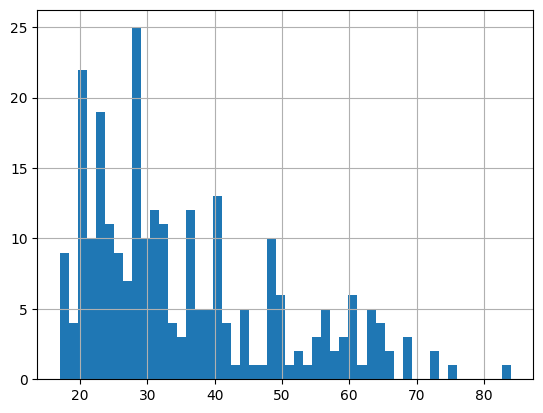

In [103]:
prediction_table[prediction_table.misclassified]["talkerage"].hist(bins=50)


In [105]:
prediction_table[prediction_table.misclassified]["talkerage"].value_counts().reset_index().sort_values(by="talkerage")

,talkerage,count
26,17,4
17,18,5
24,19,4
12,20,7
1,21,15
7,22,10
0,23,19
14,24,6
18,25,5
8,26,9


In [118]:
table = prediction_table.talkerage.value_counts().reset_index().sort_values(by="talkerage").merge(prediction_table[prediction_table.misclassified]["talkerage"].value_counts().reset_index().sort_values(by="talkerage").rename(columns={"count": "misclassified"}), on="talkerage", how="left")
table["ratio"] = table.misclassified / table["count"]
table

,talkerage,count,misclassified,ratio
0,17,18,4.0,0.222222
1,18,23,5.0,0.217391
2,19,68,4.0,0.058824
3,20,127,7.0,0.055118
4,21,99,15.0,0.151515
...,...,...,...,...
67,84,2,1.0,0.500000
68,85,1,NaN,NaN
69,87,1,NaN,NaN
70,89,1,NaN,NaN


In [129]:
prediction_table.sort_values(by="talkerage")[["talkerage", "label", "final"]].groupby(["talkerage", "label", "final"])["final"].count().to_excel("output.xlsx")